In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import img_to_array, load_img
import random


np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [3]:
import os
import numpy as np
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
# from keras.utils.vis_utils import plot_model

In [4]:
DATA_DIR = '/content/drive/MyDrive/Alzheimer'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'Train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'Validation')

In [5]:
IMG_SIZE = 128
CATEGORIES = []
for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
print(CATEGORIES)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented']


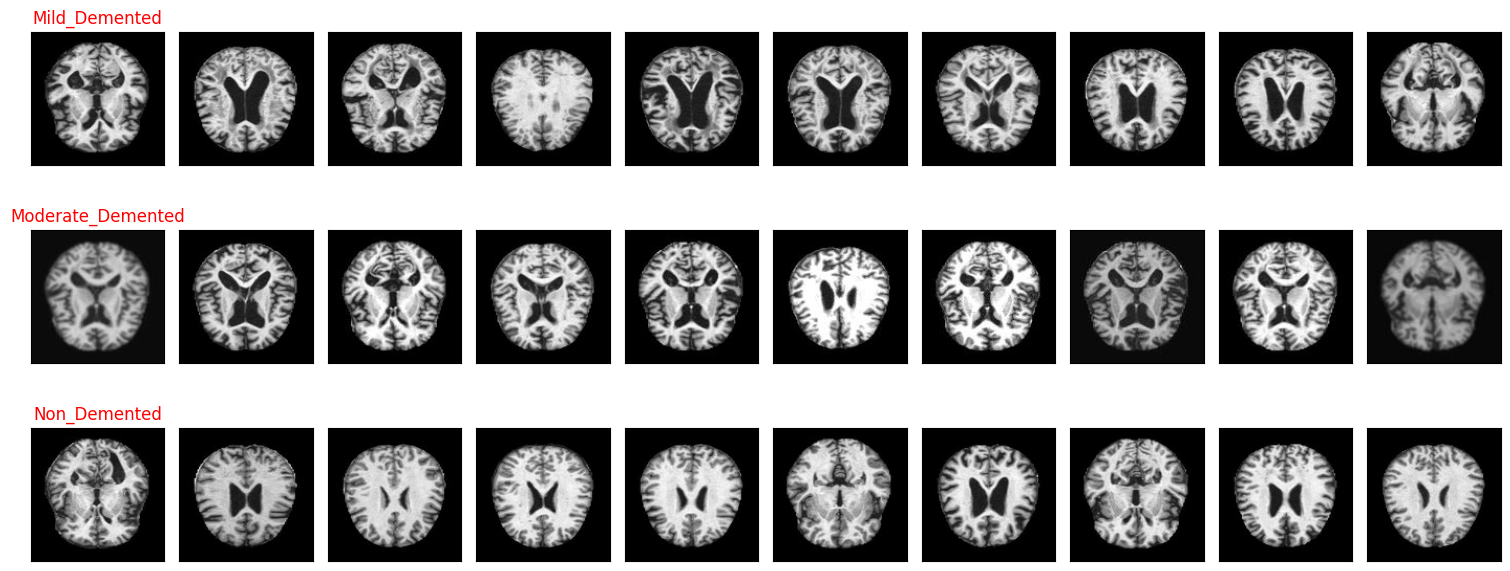

In [ ]:
plt.figure(figsize=(15, 20), facecolor='white')
i = 1
for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    random.shuffle(image_list)
    image_list = image_list[:10]
    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        white_background = 255 * np.ones_like(img_array)
        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1], :] = img_array
        plt.subplot(10, 10, i)
        plt.imshow(white_background)
        if i % 10 == 1:
            plt.title(c, color='red')
        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()

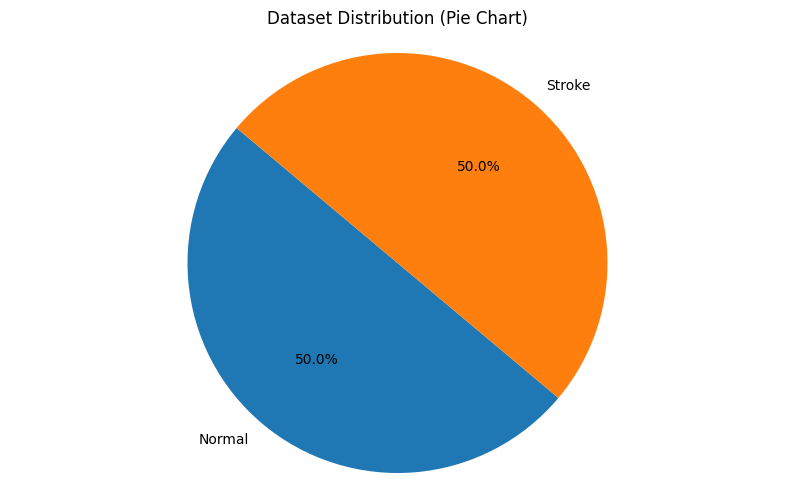

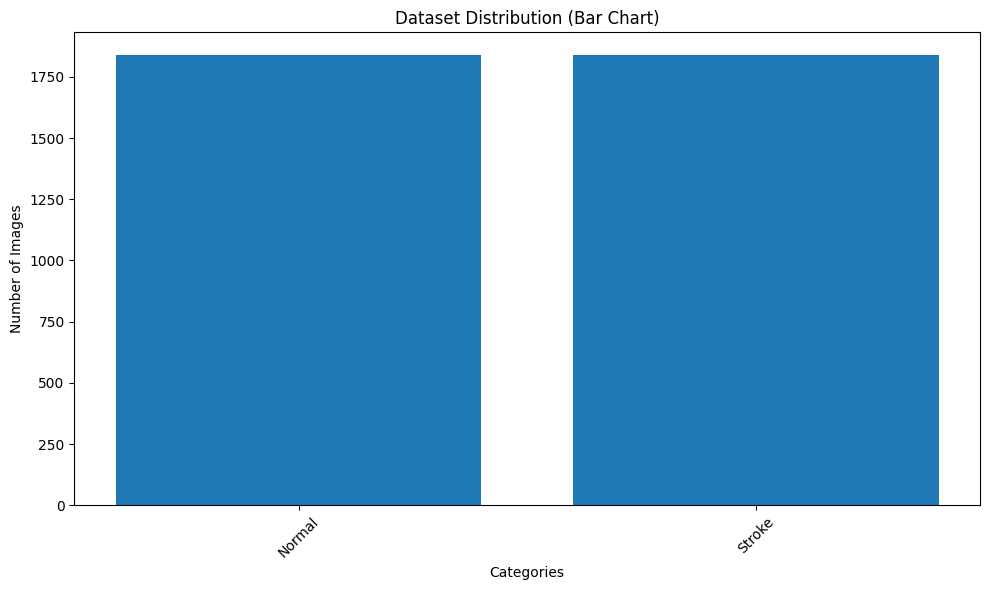

In [ ]:
category_counts = {}
for category in CATEGORIES:
    category_path = os.path.join(TRAIN_DATA_DIR, category)
    num_images = len(os.listdir(category_path))
    category_counts[category] = num_images


plt.figure(figsize=(10, 6), facecolor='white')
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Dataset Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution (Bar Chart)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

100%|██████████| 800/800 [00:16<00:00, 49.70it/s] 

2400


In [7]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

100%|██████████| 200/200 [00:04<00:00, 40.90it/s] 

600


In [8]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (2400, 128, 128, 3) Y_train= (2400,)


In [9]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0

X_test= (600, 128, 128, 3) Y_test= (600,)


Basic CNN

In [ ]:
bcnn_model = Sequential()
bcnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Conv2D(64, (3, 3), activation='relu'))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Conv2D(128, (3, 3), activation='relu'))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Flatten())
bcnn_model.add(Dense(128, activation='relu'))
bcnn_model.add(Dropout(0.5))
bcnn_model.add(BatchNormalization())
bcnn_model.add(Dense(4, activation='softmax'))

In [ ]:
bcnn_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bcnn = bcnn_model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=96)

Epoch 1/100
25/25 [==============================] - 19s 71ms/step - loss: 1.3014 - accuracy: 0.4067 - val_loss: 1.3380 - val_accuracy: 0.4183
Epoch 2/100
25/25 [==============================] - 1s 49ms/step - loss: 0.7588 - accuracy: 0.7367 - val_loss: 0.7958 - val_accuracy: 0.7533
Epoch 3/100
25/25 [==============================] - 1s 49ms/step - loss: 0.3715 - accuracy: 0.8921 - val_loss: 0.6864 - val_accuracy: 0.8100
Epoch 4/100
25/25 [==============================] - 1s 48ms/step - loss: 0.2114 - accuracy: 0.9463 - val_loss: 0.5985 - val_accuracy: 0.8600
Epoch 5/100
25/25 [==============================] - 1s 50ms/step - loss: 0.1435 - accuracy: 0.9646 - val_loss: 0.6193 - val_accuracy: 0.8733
Epoch 6/100
25/25 [==============================] - 1s 49ms/step - loss: 0.0845 - accuracy: 0.9875 - val_loss: 0.5310 - val_accuracy: 0.8917
Epoch 7/100
25/25 [==============================] - 1s 48ms/step - loss: 0.0595 - accuracy: 0.9925 - val_loss: 0.5359 - val_accuracy: 0.8750
Epoch

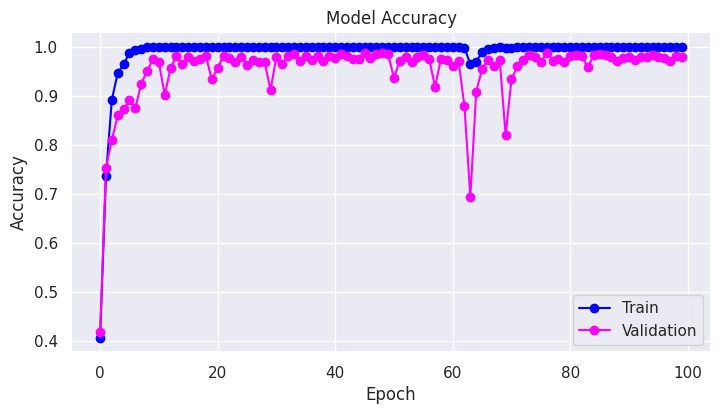

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(bcnn.history['accuracy'], 'o-',color="blue")
plt.plot(bcnn.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

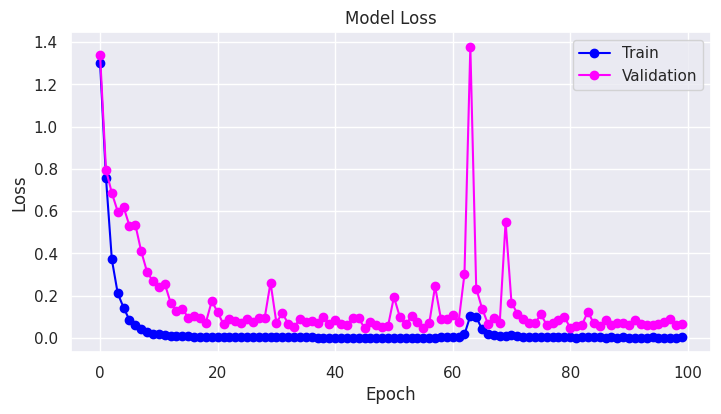

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(bcnn.history['loss'],'o-', color="blue")
plt.plot(bcnn.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
test_loss, test_acc = bcnn_model.evaluate(X_test, Y_test)
train_loss, train_acc=bcnn_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

75/75 [==============================] - 1s 10ms/step - loss: 4.1504e-05 - accuracy: 1.0000

Test Accuracy: 0.9800000190734863

Test Loss: 0.0670015811920166

Train Accuracy: 1.0

Train Loss: 4.150371387368068e-05


In [ ]:
score = bcnn_model.evaluate(X_test,Y_test,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  98.0 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(bcnn_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

19/19 [==============================] - 1s 11ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[190,   2,   8],
       [  0, 200,   0],
       [  2,   0, 198]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

                   precision    recall  f1-score   support

    Mild_Demented      0.990     0.950     0.969       200
Moderate_Demented      0.990     1.000     0.995       200
     Non_Demented      0.961     0.990     0.975       200

         accuracy                          0.980       600
        macro avg      0.980     0.980     0.980       600
     weighted avg      0.980     0.980     0.980       600



In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Mild_Demented', 'Non_Demented', 'Moderate_Demented'] , columns = ['Mild_Demented', 'Non_Demented',  'Moderate_Demented'])

<Axes: title={'center': 'Confusion Matrix'}>

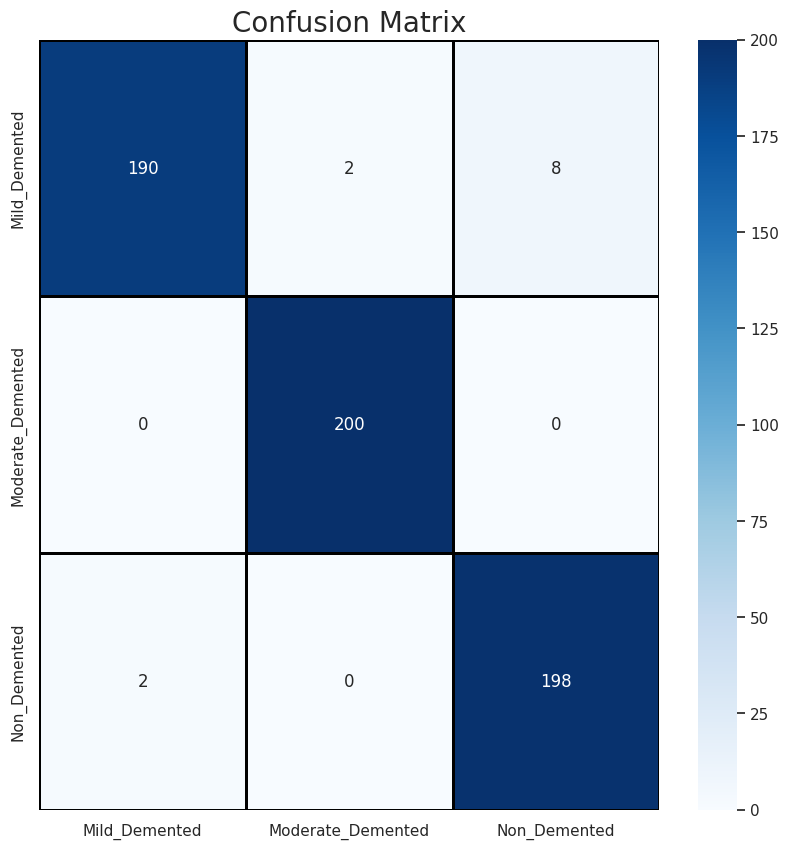

In [ ]:
plt.figure(figsize = (10,10))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

19/19 [==============================] - 0s 7ms/step


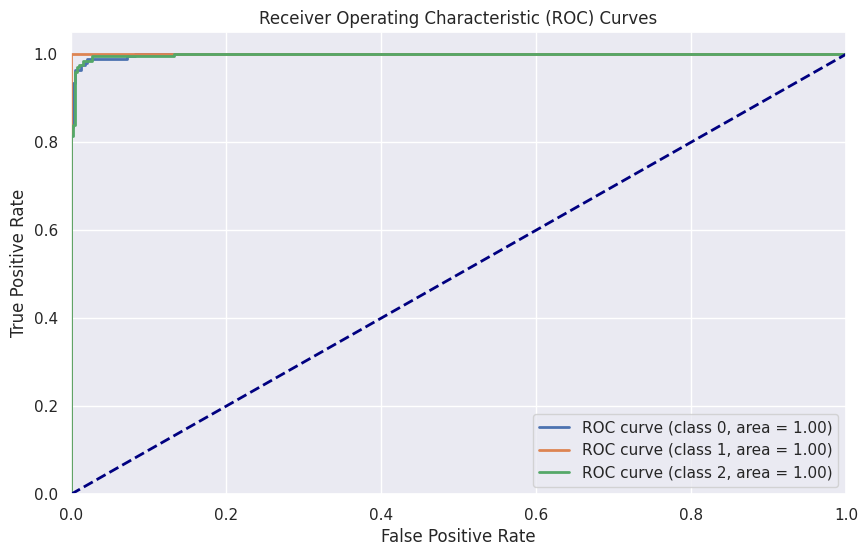

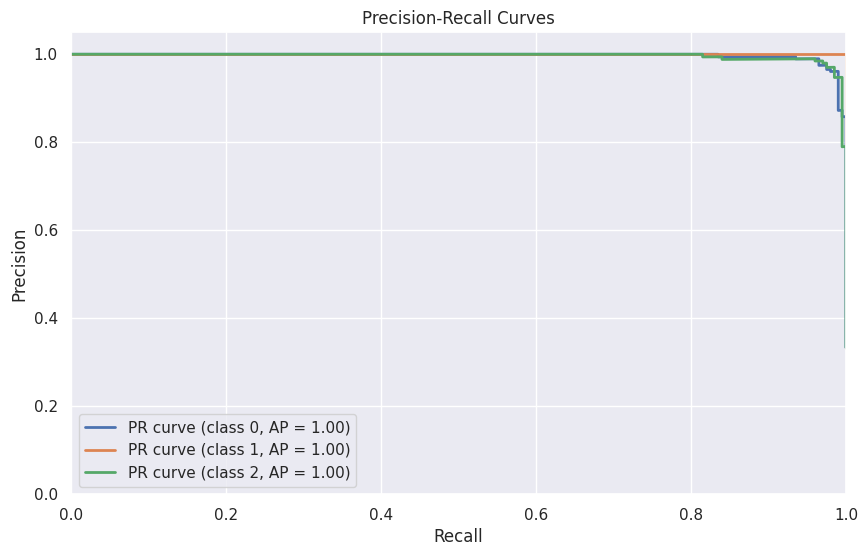

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = bcnn_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

Modified **CNN**

In [ ]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=(128,128,3)),

    ## hidden layer
    layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'), # input->(32,32) output->(28,28)
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    #layers.BatchNormalization(),

    #layers.Dense(64, activation='relu'),
    #layers.BatchNormalization(),

    #layers.Dense(64, activation='relu'),
    #layers.BatchNormalization(),

    ## output layer
    layers.Dense(4, activation='softmax')
])
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 batch_normalization_1 (Bat  (None, 124, 124, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 batch_normalization_2 (Bat  (None, 60, 60, 64)        256       
 chNormalization)                                                
                                                      

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#@title Default title text
h = model.fit(x=X_train, y=Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/100
38/38 [==============================] - 6s 69ms/step - loss: 1.5188 - accuracy: 0.7175 - val_loss: 6.6187 - val_accuracy: 0.0000e+00
Epoch 2/100
38/38 [==============================] - 2s 43ms/step - loss: 0.1921 - accuracy: 0.9250 - val_loss: 11.1572 - val_accuracy: 0.0000e+00
Epoch 3/100
38/38 [==============================] - 2s 41ms/step - loss: 0.1343 - accuracy: 0.9450 - val_loss: 9.5571 - val_accuracy: 0.0033
Epoch 4/100
38/38 [==============================] - 2s 42ms/step - loss: 0.0762 - accuracy: 0.9725 - val_loss: 8.3536 - val_accuracy: 0.2350
Epoch 5/100
38/38 [==============================] - 2s 42ms/step - loss: 0.0467 - accuracy: 0.9871 - val_loss: 8.1732 - val_accuracy: 0.3333
Epoch 6/100
38/38 [==============================] - 2s 42ms/step - loss: 0.0272 - accuracy: 0.9954 - val_loss: 7.3937 - val_accuracy: 0.3333
Epoch 7/100
38/38 [==============================] - 2s 42ms/step - loss: 0.0177 - accuracy: 0.9971 - val_loss: 5.6707 - val_accuracy: 0.33

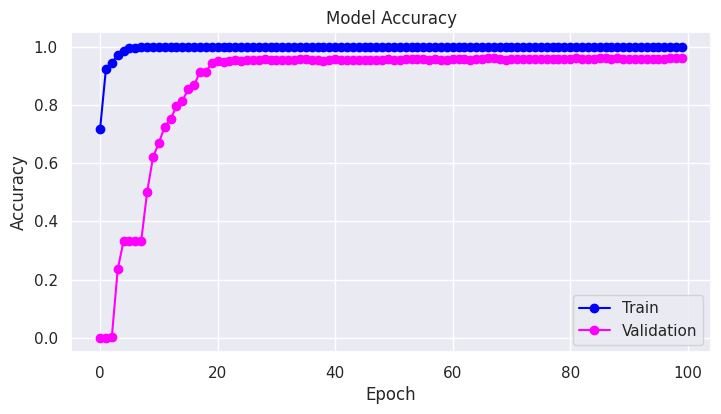

In [ ]:
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(h.history['accuracy'], 'o-',color="blue")
plt.plot(h.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

#plt.close()



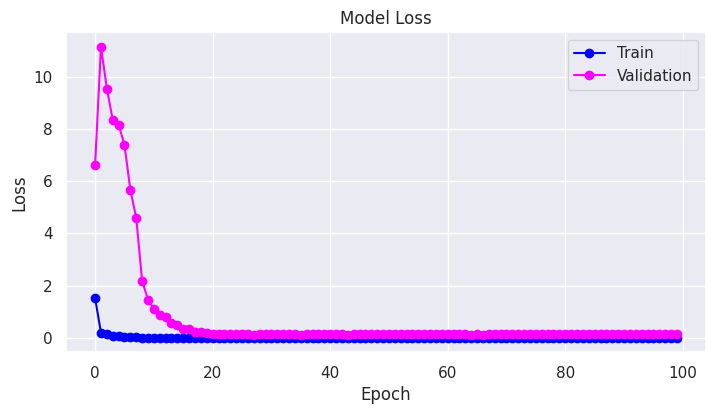

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(h.history['loss'],'o-', color="blue")
plt.plot(h.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])



In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
train_loss, train_acc=model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

75/75 [==============================] - 1s 10ms/step - loss: 8.6474e-06 - accuracy: 1.0000

Test Accuracy: 0.9599999785423279

Test Loss: 0.1402759552001953

Train Accuracy: 1.0

Train Loss: 8.64735648065107e-06


In [ ]:
score = model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  96.0 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)


19/19 [==============================] - 0s 7ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 2 0 0 0 0 2 0 2 2 0 0 0 0 0 2 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 2 0 2 0 0 0 0 0 0 0 0 0 0
 2 0 0 2 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[177,   3,  20],
       [  0, 200,   0],
       [  1,   0, 199]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = ['Mild_Demented', 'Non_Demented', 'Moderate_Demented']))

                   precision    recall  f1-score   support

    Mild_Demented      0.994     0.885     0.937       200
     Non_Demented      0.985     1.000     0.993       200
Moderate_Demented      0.909     0.995     0.950       200

         accuracy                          0.960       600
        macro avg      0.963     0.960     0.960       600
     weighted avg      0.963     0.960     0.960       600



In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Mild_Demented', 'Non_Demented', 'Moderate_Demented'] , columns = ['Mild_Demented', 'Non_Demented',  'Moderate_Demented'])

<Axes: title={'center': 'Confusion Matrix'}>

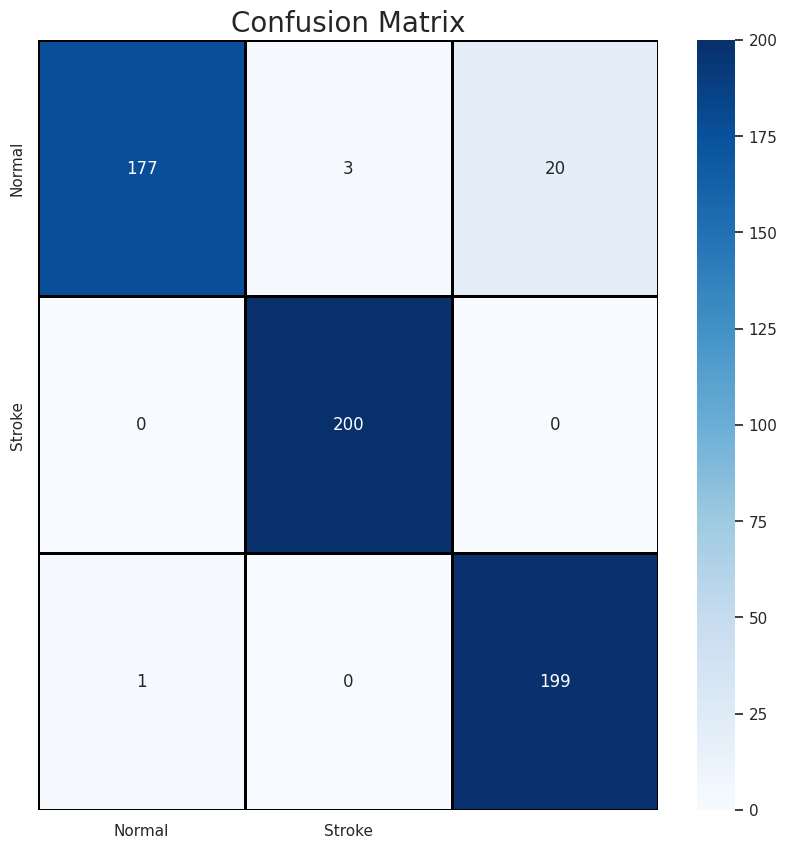

In [ ]:
plt.figure(figsize = (10,10))
ct= ['Normal', 'Stroke']
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)


19/19 [==============================] - 0s 7ms/step


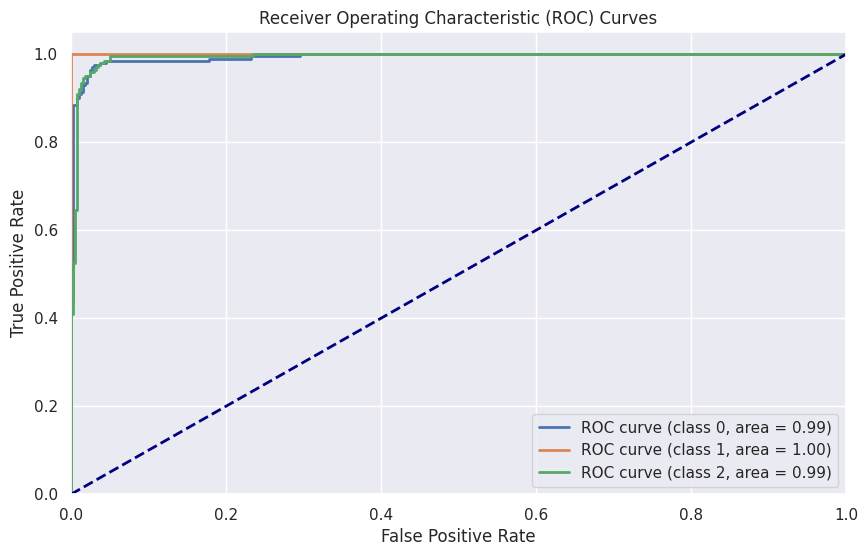

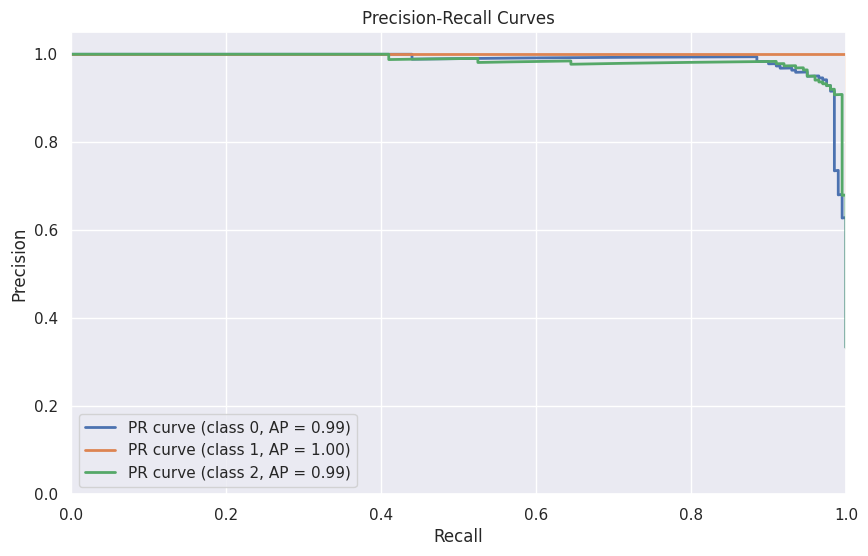

In [ ]:
# Calculate ROC and PR curves for each class
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

### ALEXNET

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
alexnet_model = keras.Sequential([
    ## input layer
    keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.Dropout(0.2),

    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.Dropout(0.2),

    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(1,1), strides=(1,1), padding='valid'),
    layers.Dropout(0.4),

    layers.Flatten(),

    layers.Dense(units=64),
    layers.Activation('relu'),

    layers.Dense(units=128),
    layers.Activation('relu'),

    layers.Dense(units=64),
    layers.Activation('relu'),

    layers.Dense(units=10),
    layers.Activation('relu'),

    layers.Dense(len(CATEGORIES)),
    layers.Activation('softmax')
])

In [ ]:
alexnet_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
alexnet = alexnet_model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/100
38/38 [==============================] - 5s 58ms/step - loss: 0.9591 - accuracy: 0.5163 - val_loss: 0.9225 - val_accuracy: 0.6000
Epoch 2/100
38/38 [==============================] - 2s 45ms/step - loss: 0.4995 - accuracy: 0.7933 - val_loss: 0.5085 - val_accuracy: 0.8400
Epoch 3/100
38/38 [==============================] - 2s 47ms/step - loss: 0.3015 - accuracy: 0.8850 - val_loss: 0.5316 - val_accuracy: 0.7983
Epoch 4/100
38/38 [==============================] - 2s 47ms/step - loss: 0.2387 - accuracy: 0.9071 - val_loss: 0.3393 - val_accuracy: 0.8467
Epoch 5/100
38/38 [==============================] - 2s 44ms/step - loss: 0.1789 - accuracy: 0.9262 - val_loss: 0.2730 - val_accuracy: 0.8750
Epoch 6/100
38/38 [==============================] - 2s 43ms/step - loss: 0.1558 - accuracy: 0.9396 - val_loss: 0.2828 - val_accuracy: 0.8650
Epoch 7/100
38/38 [==============================] - 2s 42ms/step - loss: 0.1426 - accuracy: 0.9400 - val_loss: 0.3236 - val_accuracy: 0.8567
Epoch 

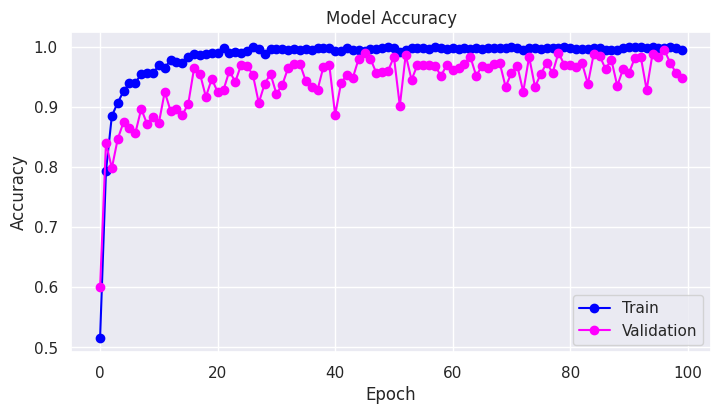

In [ ]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(alexnet.history['accuracy'], 'o-',color="blue")
plt.plot(alexnet.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

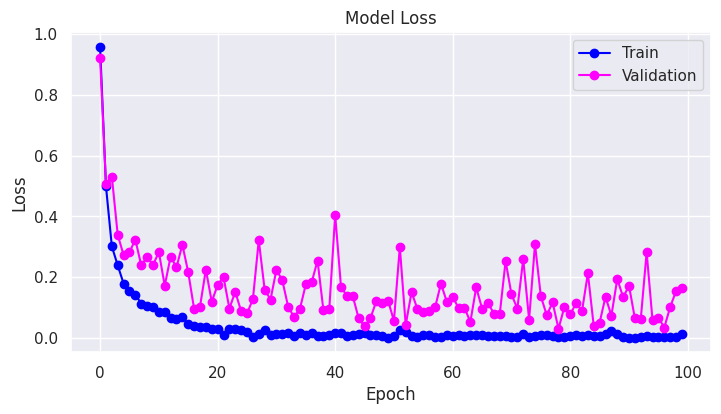

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(alexnet.history['loss'],'o-', color="blue")
plt.plot(alexnet.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])


In [ ]:
test_loss, test_acc = alexnet_model.evaluate(X_test, Y_test)
train_loss, train_acc=alexnet_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

75/75 [==============================] - 1s 8ms/step - loss: 4.2572e-04 - accuracy: 1.0000

Test Accuracy: 0.9483333230018616

Test Loss: 0.16277888417243958

Train Accuracy: 1.0

Train Loss: 0.00042571788071654737


In [ ]:
score = alexnet_model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  94.833 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(alexnet_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

19/19 [==============================] - 0s 8ms/step
[0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 2 0 0 0 0 0 2 0 2 0 0 2 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 2 0 2 2 0 0 2 0 0 0 0 0 0 2
 2 0 0 2 2 0 0 0 0 2 0 0 2 0 0 2 0 0 2 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[171,   1,  28],
       [  0, 200,   0],
       [  2,   0, 198]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

                   precision    recall  f1-score   support

    Mild_Demented      0.988     0.855     0.917       200
Moderate_Demented      0.995     1.000     0.998       200
     Non_Demented      0.876     0.990     0.930       200

         accuracy                          0.948       600
        macro avg      0.953     0.948     0.948       600
     weighted avg      0.953     0.948     0.948       600



In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Mild_Demented', 'Non_Demented', 'Moderate_Demented'] , columns = ['Mild_Demented', 'Non_Demented',  'Moderate_Demented'])

<Axes: title={'center': 'Confusion Matrix'}>

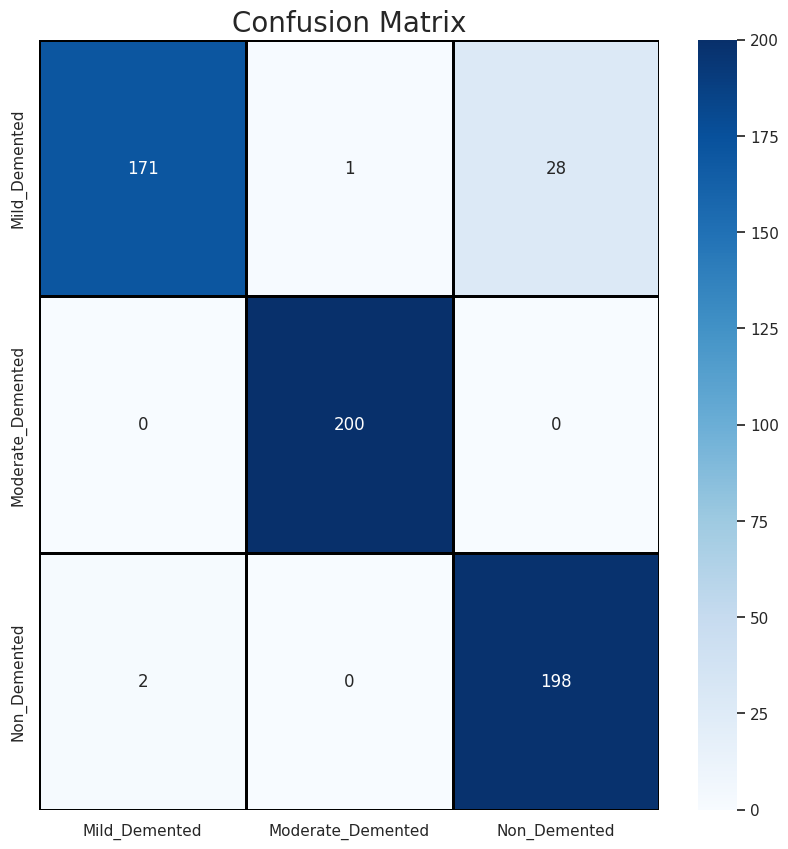

In [ ]:
plt.figure(figsize = (10,10))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

19/19 [==============================] - 0s 8ms/step


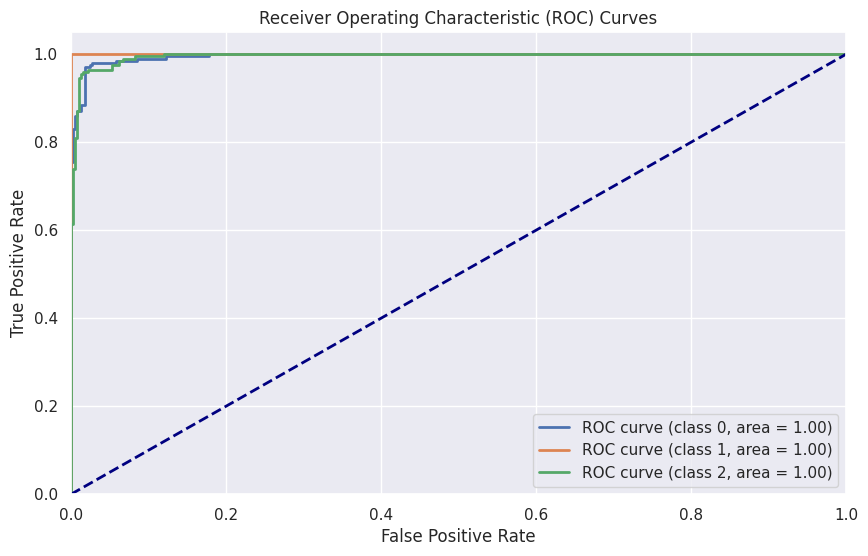

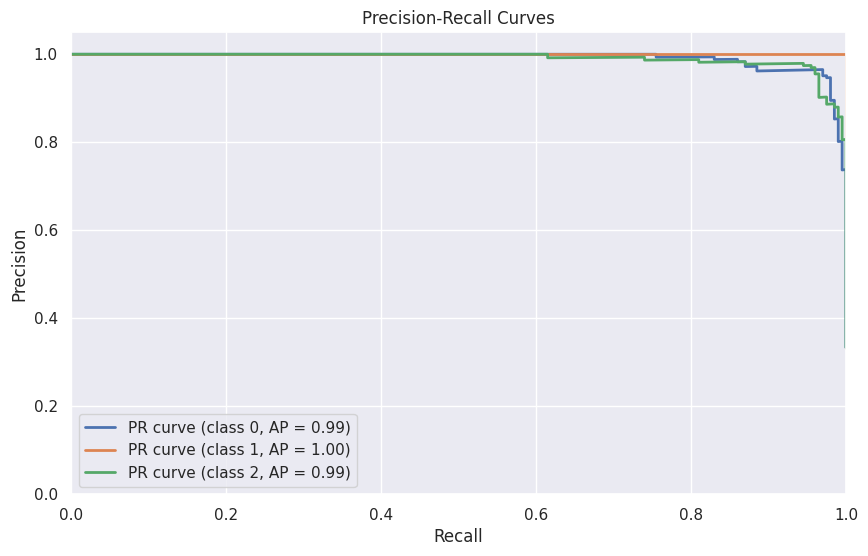

In [ ]:
# Calculate ROC and PR curves for each class
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = alexnet_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

### VGG16

In [12]:
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam

VGG16_basic_model = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
# Freeze all layers of the pre-trained model
for layer in VGG16_basic_model.layers:
    layer.trainable = False
VGG16_model = Sequential()
VGG16_model.add(VGG16_basic_model)
VGG16_model.add(Flatten())
VGG16_model.add(Dense(128, activation='relu'))
VGG16_model.add(Dense(10, activation='softmax'))
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
VGG16_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [13]:
VGG16_pretrained = VGG16_model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/100
38/38 [==============================] - 19s 202ms/step - loss: 0.8543 - accuracy: 0.6633 - val_loss: 0.6406 - val_accuracy: 0.7200
Epoch 2/100
38/38 [==============================] - 4s 97ms/step - loss: 0.3600 - accuracy: 0.8838 - val_loss: 0.4381 - val_accuracy: 0.8167
Epoch 3/100
38/38 [==============================] - 4s 98ms/step - loss: 0.2494 - accuracy: 0.9221 - val_loss: 0.3644 - val_accuracy: 0.8467
Epoch 4/100
38/38 [==============================] - 4s 112ms/step - loss: 0.1933 - accuracy: 0.9442 - val_loss: 0.3070 - val_accuracy: 0.8700
Epoch 5/100
38/38 [==============================] - 4s 116ms/step - loss: 0.1511 - accuracy: 0.9621 - val_loss: 0.3771 - val_accuracy: 0.8283
Epoch 6/100
38/38 [==============================] - 4s 113ms/step - loss: 0.1786 - accuracy: 0.9329 - val_loss: 0.5524 - val_accuracy: 0.7867
Epoch 7/100
38/38 [==============================] - 4s 99ms/step - loss: 0.1395 - accuracy: 0.9525 - val_loss: 0.3615 - val_accuracy: 0.8383
E

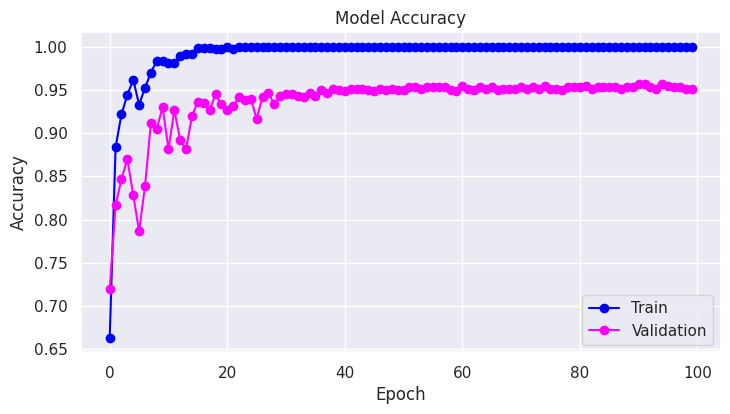

In [14]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(VGG16_pretrained.history['accuracy'], 'o-',color="blue")
plt.plot(VGG16_pretrained.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

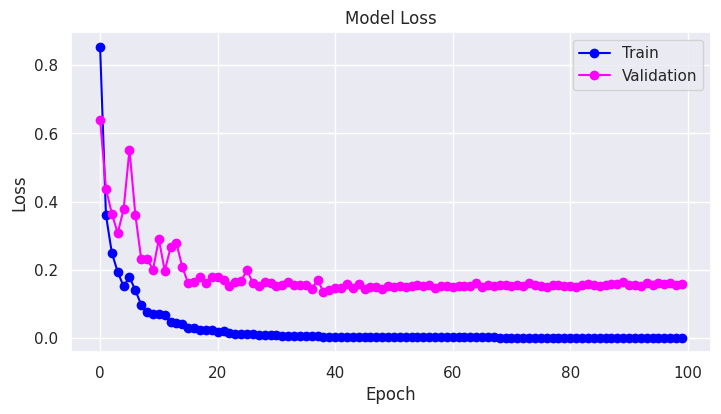

In [15]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(VGG16_pretrained.history['loss'],'o-', color="blue")
plt.plot(VGG16_pretrained.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [16]:
test_loss, test_acc = VGG16_model.evaluate(X_test, Y_test)
train_loss, train_acc=VGG16_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

75/75 [==============================] - 3s 43ms/step - loss: 3.1866e-04 - accuracy: 1.0000

Test Accuracy: 0.9516666531562805

Test Loss: 0.1577591896057129

Train Accuracy: 1.0

Train Loss: 0.00031866063363850117


In [17]:
score = VGG16_model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  95.167 %


In [18]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(VGG16_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

19/19 [==============================] - 1s 45ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 0 0 0 0 2 0 2 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

In [19]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[183,   0,  17],
       [  0, 200,   0],
       [ 12,   0, 188]])

In [20]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

                   precision    recall  f1-score   support

    Mild_Demented      0.938     0.915     0.927       200
Moderate_Demented      1.000     1.000     1.000       200
     Non_Demented      0.917     0.940     0.928       200

         accuracy                          0.952       600
        macro avg      0.952     0.952     0.952       600
     weighted avg      0.952     0.952     0.952       600



In [21]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Mild_Demented', 'Non_Demented', 'Moderate_Demented'] , columns = ['Mild_Demented', 'Non_Demented',  'Moderate_Demented'])

<Axes: title={'center': 'Confusion Matrix'}>

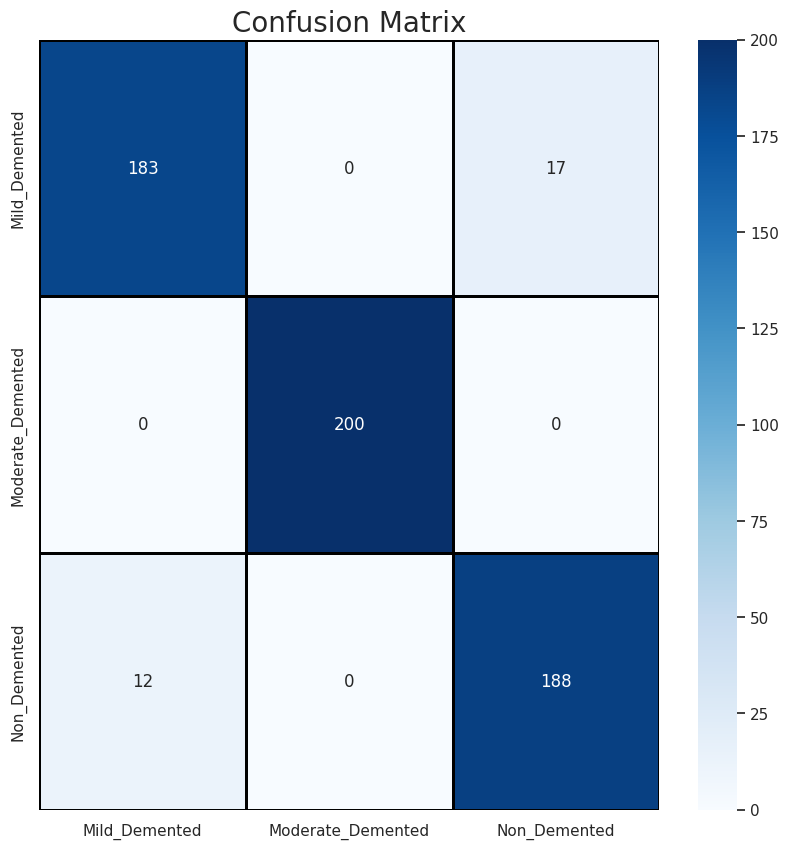

In [22]:
plt.figure(figsize = (10,10))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

19/19 [==============================] - 1s 44ms/step


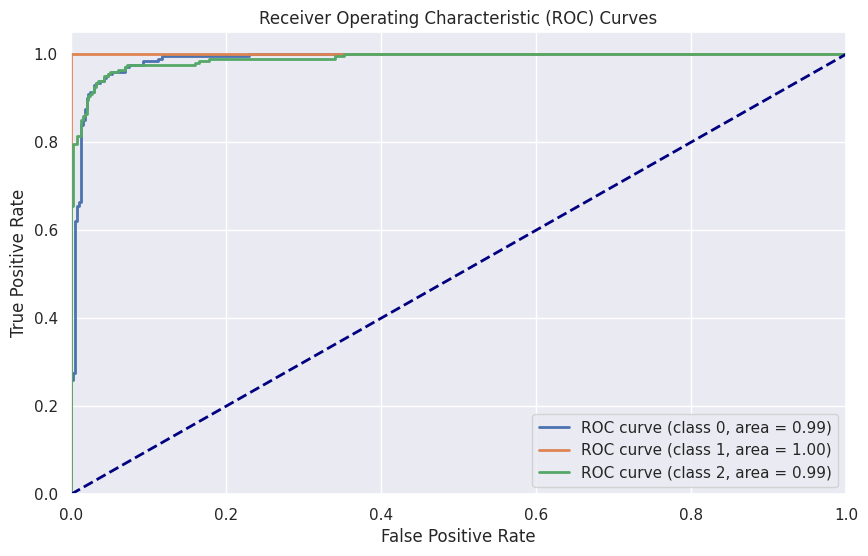

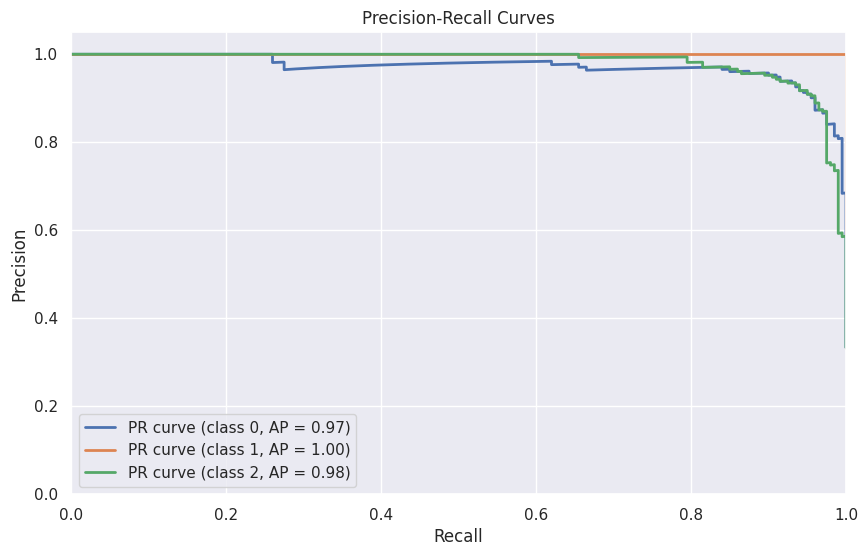

In [23]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = VGG16_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()